In [1]:
import gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
env = gym.make('CartPole-v0') #MsPacman-v0
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)
print("Actions space:", env.action_space)

State space: Box(4,)
- low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
- high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Actions space: Discrete(2)


In [3]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    return [np.linspace(low[i], high[i], num=(bins[i]+1))[1:-1] for i in range(len(low))]

def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return [np.digitize(sample[i], grid[i]) for i in range(len(grid)) ]

In [4]:
class GymAgent:

    def __init__(self, nS=(210, 160, 3), nA=9, state_grid=None, gamma=0.9, alpha=0.1, eps=0.9):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        """
        self.nA = nA
        self.state_grid = state_grid
        self.gamma = gamma
        self.alpha = 0.1
        self.eps = eps
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    def convertState(self, state):
        return tuple(np.array(discretize(state, self.state_grid)))
    
    def getExpectedValue(self, state):
        sk = self.convertState(state)
        #sk = str(tuple(current_state.flatten())).replace(', ','')
        ev = (1-self.eps)*np.argmax(self.Q[sk])+(self.eps/self.nA)*sum([self.Q[sk][ai] for ai in range(self.nA)])
        return ev

    def select_action(self, state, mode='train'):
        """ Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        sk = self.convertState(state)
        
        if mode == 'train' and np.random.rand() < self.eps:
            a = np.random.choice(self.nA)
        else:
            a = np.argmax(self.Q[sk])
        
        return a

    def update_Q(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        sk = self.convertState(state)
        #sk = str(tuple(current_state.flatten())).replace(', ','')
        target_value = reward + self.gamma*self.getExpectedValue(next_state)
        current_value = self.Q[sk][action]
        self.Q[sk][action] += self.alpha*(target_value - current_value)
        
    def run(self, env, num_episodes=100, mode='train'):
        average_score = []
        tmp_score_hist = []
        for t in range(num_episodes):
            score = 0
            init_state = env.reset()
            current_state = init_state
            while True:
                #action = env.action_space.sample()
                action = self.select_action(current_state, mode)
                
                if mode=='test':
                    env.render()

                next_state, reward, done, _ = env.step(action)
                if mode=='train':
                    self.update_Q(current_state, action, reward, next_state, done)
                score += reward
                if done:
                    tmp_score_hist.append(score)
                    break
                else:
                    current_state = next_state
            #end of while loop

            if t%(num_episodes/10) == 0: #decay eps
                gym_agent.eps = max(gym_agent.eps*0.95,0.1)
                
            if t%100 == 0:
                avg_score = sum(tmp_score_hist)/len(tmp_score_hist)
                tmp_score_hist = []
                average_score.append(avg_score)
                print("\rEpisode {}/{}. Score: {}. Qtable size: {}. eps: {}.   ".format(t, num_episodes, 
                                                                                        avg_score, 
                                                                                        len(gym_agent.Q),
                                                                                        gym_agent.eps), end="")
                sys.stdout.flush()
            #end of one episode
        return average_score

In [6]:
bins = tuple([80 for i in range(len(env.observation_space.high))])
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=bins)
gym_agent = GymAgent(env.observation_space.shape, env.action_space.n, state_grid)

In [ ]:
average_score = gym_agent.run(env, 5000000, mode='train')       
plt.plot(average_score)
#env.close()

Episode 303500/5000000. Score: 23.7. Qtable size: 3812. eps: 0.855.    

In [13]:
average_score = gym_agent.run(env, 2, mode='test')

Episode 0/2. Score: 28.0. Qtable size: 1342. eps: 0.5119200830488138.   

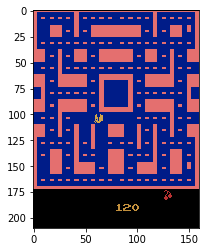